# Explanatory Data Analysis, Feature Engineering and Feature Selection

This notebook is dedicated to explanatory data analysis (EDA), feature engineering, and feature selection to better understand the datasets, extract meaningful features, and identify the most relevant variables for stress detection and heart rate prediction tasks. The goal is also to use and test the hrv calculation method, that uses a list of heart rates in order to produce an accurate set of hrv values.


### Data Structure
In order to run the notebook for yourself please note that the data structure to recreate the project is the following:
```
.
├── Healthcare 
│   └── data.csv
├── Heart_Rate_Prediction
│   ├── Test Data
│   │   ├── hr_non_linear.csv
│   │   └── hr_time_domain.csv
│   └── Train Data
│       ├── hr_non_linear.csv
│       └── hr_time_domain.csv
├── SWELL
│   ├── test.csv
│   └── train.csv
└── Stress_predict
    ├── Questionnaires_scores.xlsx
    ├── Time_logs.xlsx
    └── data.csv
```

In [1]:
# Import Libraries
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hrv_calculator import compute_hrv_column_fast


# Import Data Paths
data_path = os.getcwd() + '/data' 

## Healthcare dataset for Nurse Stress Prediction with Wearable devices

- Data Collection Context:
    - Period: Data gathered over one week from 15 female nurses aged 30 to 55 years

- Data Captured:
    - Physiological Variables Monitored: Heart Rate of the nurse subjects.
    - Survey Responses: Periodic smartphone-administered surveys capturing contributing factors to detected stress events.
    - Measurement Technologies: Utilized Empatica E4 for data collection, specifically focusing on Blood Volume Pulse (BVP) readings.

- Merge CSV File Information:
    - This dataset comprises approximately 11.5 million entries across nine columns:
    - X, Y, Z: Orientation data (256 unique entries each).
    - EDA, HR, TEMP: Physiological measurements (EDA: 274,452 unique, HR: 6,268 unique, TEMP: 599 unique).
    - id: 18 categorical identifiers.
    - datetime: Extensive date and time entries (10.6 million unique).
    - label: Categorical states or classes (three unique entries).

### Explanatory Data Analysis and Feature Selection

In [2]:
# Load data and get the initial shape of the dataset
health_care_path = os.path.join(data_path, 'Healthcare/data.csv')
nurses_pd = pd.read_csv(health_care_path, dtype={'id': str}, low_memory=False)
print(f'The initial data contains {nurses_pd.shape[0]} rows and { nurses_pd.shape[1]} columns.')

# Feature Selection:
# We know that in our experiment the data we can use are Heart Rate (HR), Heart Rate Variability (HRV) and the number of steps along with the label. 
# We will keep the columns HR, label and datetime so that we can calculate the HRV values
data_pd = nurses_pd.drop(columns=['X', 'Y', 'Z', 'EDA', 'TEMP', 'id'])

data_pd['datetime'] = pd.to_datetime(data_pd['datetime'])
data_pd = data_pd.set_index('datetime')

# Resample the data to 1 second intervals and drop NaN Values
resampled = data_pd.resample('1s').mean().dropna().reset_index()

# Ensure that the labels are in the correct format
resampled['label'] = resampled['label'].astype(str).str.extract(r'(\d+)')
resampled['label'] = resampled['label'].astype(int)
print(f'The data we are interested in contains {resampled.shape[0]} rows and {resampled.shape[1]} columns.')

The initial data contains 11509051 rows and 9 columns.
The data we are interested in contains 332307 rows and 3 columns.


In [ ]:
# Create the new column for Heart Rate Variability (HRV)
resampled['HRV'] = compute_hrv_column_fast(resampled, use_jitter=True)

# Export the data and delete downsampled data
resampled = resampled[['HR', 'HRV', 'datetime', 'label']]
print('The data with HRV contains {} rows and {} columns.'.format(resampled.shape[0], resampled.shape[1]))

/Users/stamatiosorphanos/Desktop/Stress_Detection/hrv_calculator.py:24: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  time_deltas.iloc[0] = 1  # prevent NaN at start


The data with HRV contains 332307 rows and 4 columns.


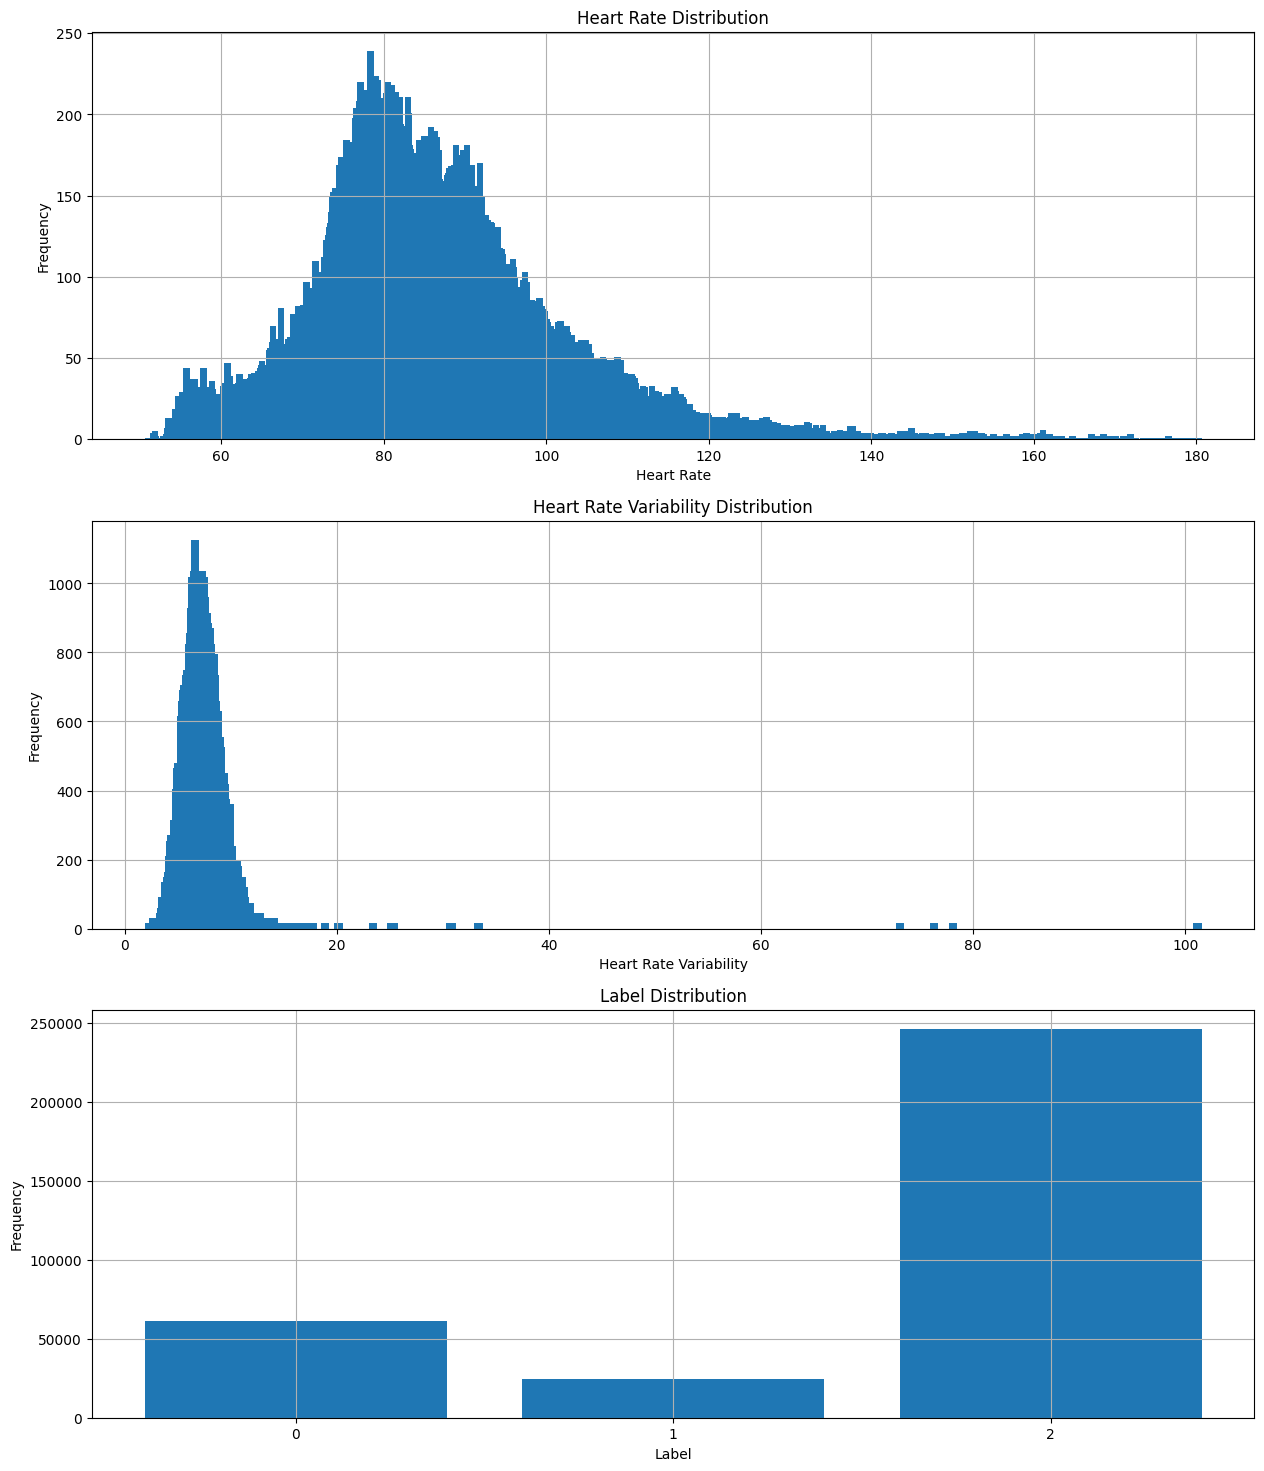

In [ ]:
# Plot statistical data for the dataset
labels = resampled['label'].value_counts()

nrows = 3
ncols = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 18))

axs[0].bar(resampled['HR'].value_counts().index, resampled['HR'].value_counts().values)
axs[0].set_title('Heart Rate Distribution')
axs[0].set_xlabel('Heart Rate')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].bar(resampled['HRV'].value_counts().index, resampled['HRV'].value_counts().values)
axs[1].set_title('Heart Rate Variability Distribution')
axs[1].set_xlabel('Heart Rate Variability')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)


axs[2].bar(labels.index, labels.values)
axs[2].set_title('Label Distribution')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Frequency')
axs[2].set_xticks(labels.index)
axs[2].set_xticklabels(labels.index.astype(int))

---

## Heart Rate Prediction to Monitor Stress Level
The data comprises various attributes taken from signals measured using ECG recorded for different individuals having different heart rates at the time the measurement was taken. These various features contribute to the heart rate at the given instant of time for the individual.

There are total of 6 CSV files with the names as follows:
- Train:
    - time_domain_features_train.csv - This file contains all time domain features of heart rate for training data
    - frequency_domain_features_train.csv - This file contains all frequency domain features of heart rate for training data
    - heart_rate_non_linear_features_train.csv - This file contains all non linear features of heart rate for training data

- Test: 
    - time_domain_features_test.csv - This file contains all time domain features of heart rate for testing data
    - frequency_domain_features_test.csv - This file contains all frequency domain features of heart rate for testing data
    - heart_rate_non_linear_features_test.csv - This file contains all non linear features of heart rate for testing data

Following is the data dictionary for the features you will come across in the files mentioned:
- MEAN_RR - Mean of RR intervals
- MEDIAN_RR - Median of RR intervals
- SDRR - Standard deviation of RR intervals
- **RMSSD - Root mean square of successive RR interval differences**
- SDSD - Standard deviation of successive RR interval differences
- SDRR_RMSSD - Ratio of SDRR / RMSSD
- pNN25 - Percentage of successive RR intervals that differ by more than 25 ms
- pNN50 - Percentage of successive RR intervals that differ by more than 50 ms
- KURT - Kurtosis of distribution of successive RR intervals
- SKEW - Skew of distribution of successive RR intervals
- MEAN_REL_RR - Mean of relative RR intervals
- MEDIAN_REL_RR - Median of relative RR intervals
- SDRR_REL_RR - Standard deviation of relative RR intervals
- RMSSD_REL_RR - Root mean square of successive relative RR interval differences
- SDSD_REL_RR - Standard deviation of successive relative RR interval differences
- SDRR_RMSSD_REL_RR - Ratio of SDRR/RMSSD for relative RR interval differences
- KURT_REL_RR - Kurtosis of distribution of relative RR intervals
- SKEW_REL_RR - Skewness of distribution of relative RR intervals
- **uuid - Unique ID for each patient**
- VLF - Absolute power of the very low frequency band (0.0033 - 0.04 Hz)
- VLF_PCT - Principal component transform of VLF
- LF - Absolute power of the low frequency band (0.04 - 0.15 Hz)
- LF_PCT - Principal component transform of LF
- LF_NU - Absolute power of the low frequency band in normal units
- HF - Absolute power of the high frequency band (0.15 - 0.4 Hz)
- HF_PCT - Principal component transform of HF
- HF_NU - Absolute power of the highest frequency band in normal units
- TP - Total power of RR intervals
- LF_HF - Ratio of LF to HF
- HF_LF - Ratio of HF to LF
- SD1 - Poincaré plot standard deviation perpendicular to the line of identity
- SD2 - Poincaré plot standard deviation along the line of identity
- Sampen - sample entropy which measures the regularity and complexity of a time series
- higuci - higuci fractal dimension of heartrate
- datasetId - ID of the whole dataset
- **condition - condition of the patient at the time the data was recorded**
- **HR - Heart rate of the patient at the time of data recorded**

In [ ]:
# Data path 
train_non_linear_path  = os.path.join(data_path,  'Heart_Rate_Prediction/Train_Data/hr_non_linear.csv')
train_time_domain_path = os.path.join(data_path, 'Heart_Rate_Prediction/Train_Data/hr_time_domain.csv')

test_non_linear_path  = os.path.join(data_path,  'Heart_Rate_Prediction/Test_Data/hr_non_linear.csv')
test_time_domain_path = os.path.join(data_path, 'Heart_Rate_Prediction/Test_Data/hr_time_domain.csv')

In [ ]:
# Train data pipeline
train_non_linear_df  = pd.read_csv(train_non_linear_path)
train_time_domain_df = pd.read_csv(train_time_domain_path)
print('The initial non linear  train data contains {} rows and {} columns.'.format(train_non_linear_df.shape[0], train_non_linear_df.shape[1]))
print('The initial time domain train data contains {} rows and {} columns.'.format(train_time_domain_df.shape[0], train_time_domain_df.shape[1]))

# Drop unnecessary columns and join the data in one new dataframe
train_non_linear_df = train_non_linear_df.drop(columns=['SD1', 'SD2', 'sampen', 'higuci', 'datasetId'], axis=1)

columns_to_drop = ['MEAN_RR','MEDIAN_RR','SDRR','SDSD','SDRR_RMSSD','pNN25','pNN50','KURT','SKEW','MEAN_REL_RR','MEDIAN_REL_RR','SDRR_REL_RR',
                  'RMSSD_REL_RR','SDSD_REL_RR','SDRR_RMSSD_REL_RR','KURT_REL_RR','SKEW_REL_RR']
train_time_domain_df = train_time_domain_df.drop(columns=columns_to_drop, axis=1)


# Merge the two dataframes
train_data = pd.merge(train_non_linear_df, train_time_domain_df, on=['uuid'], how='inner')
train_data['HR'] = data_pd['HR'].astype(int)
train_data.to_csv(os.path.join(data_path, 'Heart_Rate_Prediction/Train_Data/train.csv'), index=False)
print('The merged train data contains {} rows and {} columns.'.format(train_data.shape[0], train_data.shape[1]))

In [ ]:
heart_rates = train_data['HR'].value_counts()
labels = train_data['condition'].value_counts()

# Simple Statistical Analysis
mean_heart_rate = train_data['HR'].mean()
median_heart_rate = train_data['HR'].median()
std_heart_rate = train_data['HR'].std()

print('The mean heart rate is {:.2f} bpm.'.format(mean_heart_rate))
print('The median heart rate is {:.2f} bpm.'.format(median_heart_rate))
print('The standard deviation of heart rate is {:.2f} bpm.'.format(std_heart_rate))

# Plot statistical data for the dataset
nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title('Heart Rate Distribution')
axs[0].set_xlabel('Heart Rate')
axs[0].set_ylabel('Frequency')

axs[1].bar(labels.index, labels.values)
axs[1].set_title('Label Distribution')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(labels.index)

In [ ]:
# Plot statistical data for the dataset
hrvs = data_pd['HRV'].value_counts()
nrows = 1
ncols = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs.bar(hrvs.index, hrvs.values)
axs.set_title('Heart Rate Variability Distribution')
axs.set_xlabel('Heart Rate Variability')
axs.set_ylabel('Frequency')


In [ ]:
# Test data pipeline
test_non_linear_df  = pd.read_csv(test_non_linear_path)
test_time_domain_df = pd.read_csv(test_time_domain_path)
print('The initial non linear  test data contains {} rows and {} columns.'.format(test_non_linear_df.shape[0], test_non_linear_df.shape[1]))
print('The initial time domain test data contains {} rows and {} columns.'.format(test_time_domain_df.shape[0], test_time_domain_df.shape[1]))

# Drop unnecessary columns and join the data in one new dataframe
test_non_linear_df = test_non_linear_df.drop(columns=['SD1', 'SD2', 'sampen', 'higuci', 'datasetId'], axis=1)

columns_to_drop = ['MEAN_RR','MEDIAN_RR','SDRR','SDSD','SDRR_RMSSD','pNN25','pNN50','KURT','SKEW','MEAN_REL_RR','MEDIAN_REL_RR','SDRR_REL_RR',
                  'RMSSD_REL_RR','SDSD_REL_RR','SDRR_RMSSD_REL_RR','KURT_REL_RR','SKEW_REL_RR']
test_time_domain_df = test_time_domain_df.drop(columns=columns_to_drop, axis=1)


# Merge the two dataframes
test_data = pd.merge(test_non_linear_df, test_time_domain_df, on=['uuid'], how='inner')
test_data.to_csv(os.path.join(data_path, 'Heart_Rate_Prediction/Test_Data/test.csv'), index=False)
print('The merged test data contains {} rows and {} columns.'.format(test_data.shape[0], test_data.shape[1]))

In [ ]:
# Plot statistical data for the dataset
hrvs = test_data['RMSSD'].value_counts()
labels = test_data['condition'].value_counts()

nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title('Heart Rate Variability Distribution')
axs[0].set_xlabel('Heart Rate Variability')
axs[0].set_ylabel('Frequency')

axs[1].bar(labels.index, labels.values)
axs[1].set_title('Label Distribution')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(labels.index)

---

# Stress Detection Dataset

Stress-predict dataset to perform descriptive, statistical and classification analysis of biophysiological data collected from healthy individuals, who underwent various induced emotional states, to assess the relative sensitivity and specificity of common biophysiological indicators of stress and provide a stepping-stone towards the development of an accurate stress monitoring device. In this study, 35 healthy volunteers performed three different stress-inducing tasks (i.e., Stroop colour word test, interview session and hyperventilation session) with baseline/relaxation period between each task, for 60 minutes. Blood volume pulse (BVP), Inter-beat-intervals, and heart rate were continuously recorded using Empatica watches while the respiratory rate was estimated using a PPG-based respiratory rate estimation algorithm.


In [ ]:
# Load the Stress Prediction data
data = pd.read_csv(os.path.join(data_path, 'Stress_Predict/data.csv'))

heart_rates = data['HR'].value_counts()
labels = data['Label'].value_counts()

# Simple Statistical Analysis
mean_heart_rate = data['HR'].mean()
median_heart_rate = data['HR'].median()
std_heart_rate = data['HR'].std()

print('The mean heart rate is {:.2f} bpm.'.format(mean_heart_rate))
print('The median heart rate is {:.2f} bpm.'.format(median_heart_rate))
print('The standard deviation of heart rate is {:.2f} bpm.'.format(std_heart_rate))

In [ ]:
# Plot statistical data for the dataset
nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title('Heart Rate Distribution')
axs[0].set_xlabel('Heart Rate')
axs[0].set_ylabel('Frequency')

axs[1].bar(labels.index, labels.values)
axs[1].set_title('Label Distribution')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(labels.index)
axs[1].set_xticklabels(labels.index.astype(int))

In [ ]:
# Create a new column for HRV, calculate the difference between consecutive heart rates every 15 seconds
step = 15

# New HRV column to be filled
hrv_values = []

for i in range(0, len(data), step):
    chunk = data.iloc[i:i+step]
    if len(chunk) == step:
        hr_list = chunk['HR'].tolist()
        hrv_result = compute_hrv_from_heart_rate(hr_list, use_jitter=True)
        hrv_rmssd = hrv_result[0]['rmssd']
        hrv_values.extend([hrv_rmssd] * 15)
    else:
        hrv_values.extend([np.nan] * len(chunk))

# Assign to new column
data['HRV'] = hrv_values

# Export the data and delete downsampled data
data = data[['Participant', 'HR', 'HRV', 'Label']]
data.to_csv(os.path.join(data_path, 'Stress_predict/hrv.csv'), index=False)


# Plot statistical data for the dataset
hrvs = data['HRV'].value_counts()
nrows = 1
ncols = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs.bar(hrvs.index, hrvs.values)
axs.set_title('Heart Rate Variability Distribution')
axs.set_xlabel('Heart Rate Variability')
axs.set_ylabel('Frequency')

---

# SWELL

In [ ]:
# Data path 
swell_train_path= os.path.join(data_path,  'SWELL/train.csv')
swell_test_path = os.path.join(data_path,  'SWELL/test.csv')

# Load the SWELL data
swell_train_df = pd.read_csv(swell_train_path)
swell_test_df = pd.read_csv(swell_test_path)
print(swell_train_df.head())

columns = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'SDRR_RMSSD', 'SDSD', 'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 
           'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR','KURT_REL_RR', 'SKEW_REL_RR', 
           'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF', 'sampen', 'higuci', 'datasetId']

# Drop unnecessary columns and join the data in one new dataframe
swell_train_df = swell_train_df.drop(columns=columns, axis=1)
swell_test_df  = swell_test_df.drop(columns=columns, axis=1)
swell_df = pd.concat([swell_train_df, swell_test_df], ignore_index=True)

In [ ]:
heart_rates = swell_train_df['HR'].value_counts()
labels = swell_train_df['condition'].value_counts()

# Simple Statistical Analysis
mean_heart_rate = swell_train_df['HR'].mean()
median_heart_rate = swell_train_df['HR'].median()
std_heart_rate = swell_train_df['HR'].std()

print('The mean heart rate is {:.2f} bpm.'.format(mean_heart_rate))
print('The median heart rate is {:.2f} bpm.'.format(median_heart_rate))
print('The standard deviation of heart rate is {:.2f} bpm.'.format(std_heart_rate))

In [ ]:
# Plot statistical data for the dataset
rmssd = swell_train_df['RMSSD'].astype(int).value_counts()
nrows = 1
ncols = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs.bar(rmssd.index, rmssd.values)
axs.set_title('Root mean square of successive RR interval differences --- Heart Rate Variability Distribution')
axs.set_xlabel('Heart Rate Variability')
axs.set_ylabel('Frequency')